# Sentiment Model

The sentiment model is built on 7 steps:
1. Load the ProsusAI/finbert Model and Tokenizer
2. Prepare the Annotated Dataset for Tokenization
3. Define Training Arguments
4. Initialize the Trainer
5. Fine-Tune the Model
6. Evaluate the Model on Validation Data
7. Save the Model
8. Inference




### Step 1: Load the ProsusAI/finbert Model and Tokenizer

In [2]:
#All packages for entire notebook
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback
import torch
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time
from datetime import timedelta
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report


/opt/anaconda3/envs/PyTorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/PyTorch/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/PyTorch/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/PyTorch/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/PyTorch/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/PyTorch/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/PyTorch/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no su

In [2]:
# Let's first check if we are using my GPU
print(torch.__version__)          
print(torch.cuda.is_available()) 
print(torch.cuda.get_device_name(0))  

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


2.5.1+cu118
True
NVIDIA GeForce RTX 3070 Ti


In [3]:
# Load ProsusAI FinBERT tokenizer and model (3 labels)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)
model = model.to(device)


### Step 2: Prepare the Annotated Dataset for Tokenization

In [5]:
# Load annotated dataset
data = pd.read_csv("cleaned_labeled_data.csv")

# Inspect the first few rows
print(data.head())

                                                text  sentiment_label
0  trading 212 wont give this retard an account s...                0
1  theyre saying we throttled but were higher avg...                0
2  weed bet im holding for the next few months $A...                2
3                                       fuvk you all                0
4  cashapp jusr let me buy the fucking amc dip it...                1


In [6]:
# See label distribution
print("Label distribution:")
print(data['sentiment_label'].value_counts())
print("\nPercentage distribution:")
print(data['sentiment_label'].value_counts(normalize=True) * 100)

Label distribution:
sentiment_label
2    710
1    668
0    403
Name: count, dtype: int64

Percentage distribution:
sentiment_label
2    39.865244
1    37.507019
0    22.627737
Name: proportion, dtype: float64


In [7]:
# Tokenize the text
def tokenize_data(texts, labels):
    encodings = tokenizer(
        texts, truncation=True, padding=True, max_length=512, return_tensors="pt"
    )
    return encodings, torch.tensor(labels)

# Extract texts and labels
texts = data["text"].tolist()
labels = data["sentiment_label"].tolist()

# Tokenize the dataset
encodings, labels = tokenize_data(texts, labels)

print("Data tokenized successfully!")

Data tokenized successfully!


In [8]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)
# Class weights using  training labels
train_labels_array = np.array(train_labels)
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1, 2]), 
    y=train_labels_array
)

print("Class weights:", class_weights)
class_weights = torch.FloatTensor(class_weights).to(device)


# Tokenize training and validation sets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

print("Data successfully split into training and validation sets!")

Class weights: [1.46051282 0.91106846 0.82122261]
Data successfully split into training and validation sets!


In [9]:
# Create a dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx]).to(device)
        return item

# Create training and validation datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

print("Datasets are ready!")

Datasets are ready!


### Step 3: Define Training Arguments

In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",     
    save_strategy="epoch",          
    learning_rate=5e-5,             
    per_device_train_batch_size=8,  
    num_train_epochs=50,            
    weight_decay=0.01,
    warmup_ratio=0.2,              
    save_total_limit=3,               
    logging_dir="./logs",           
    logging_steps=10,               
    no_cuda=False,                  
    fp16=True,
    logging_strategy="epoch",
    disable_tqdm=True, 
    # Add learning rate scheduler settings
    lr_scheduler_type="reduce_lr_on_plateau",
    metric_for_best_model="eval_loss",
    greater_is_better=False,        
    load_best_model_at_end=True,    
    max_grad_norm=1.0
)

print("Training arguments set up!")

Training arguments set up!


c:\Users\lukas\anaconda3\envs\DeepLearning311\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Create a custom trainer class that uses class weights
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

### Step 4: Initialize the Trainer


In [12]:
# Initialize the custom trainer
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)] 
)

print("Trainer initialized successfully!")

Trainer initialized successfully!


C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\3592411705.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


### Step 5: Fine-Tune the Model


In [13]:
# See GPU usage
print(f"Current GPU memory usage: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

# Start timing
start_time = time.time()

# Begin fine-tuning
trainer.train()

# End timing
end_time = time.time()
training_time = end_time - start_time

print("Model fine-tuning complete!")
print(f"Max GPU memory usage: {torch.cuda.max_memory_allocated()/1024**2:.2f} MB")
print(f"Training time: {timedelta(seconds=int(training_time))}")
print(f"Training time in minutes: {training_time/60:.2f}")

Current GPU memory usage: 418.74 MB


C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\365778475.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx]).to(device)


{'loss': 1.0429, 'grad_norm': 15.46470832824707, 'learning_rate': 5e-05, 'epoch': 1.0}
{'eval_loss': 0.9128734469413757, 'eval_runtime': 1.5916, 'eval_samples_per_second': 224.309, 'eval_steps_per_second': 28.274, 'epoch': 1.0}


C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\365778475.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx]).to(device)


{'loss': 0.752, 'grad_norm': 8.97850513458252, 'learning_rate': 5e-05, 'epoch': 2.0}
{'eval_loss': 0.8748406767845154, 'eval_runtime': 1.5374, 'eval_samples_per_second': 232.211, 'eval_steps_per_second': 29.27, 'epoch': 2.0}


C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\365778475.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx]).to(device)


{'loss': 0.4479, 'grad_norm': 42.23569869995117, 'learning_rate': 5e-05, 'epoch': 3.0}
{'eval_loss': 1.2848297357559204, 'eval_runtime': 1.542, 'eval_samples_per_second': 231.511, 'eval_steps_per_second': 29.182, 'epoch': 3.0}


C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\365778475.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx]).to(device)


{'loss': 0.3025, 'grad_norm': 9.466876029968262, 'learning_rate': 5e-05, 'epoch': 4.0}
{'eval_loss': 1.670668601989746, 'eval_runtime': 1.5388, 'eval_samples_per_second': 231.994, 'eval_steps_per_second': 29.243, 'epoch': 4.0}


C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\365778475.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx]).to(device)


{'loss': 0.1435, 'grad_norm': 0.08020453155040741, 'learning_rate': 5e-05, 'epoch': 5.0}
{'eval_loss': 2.087724208831787, 'eval_runtime': 1.5357, 'eval_samples_per_second': 232.469, 'eval_steps_per_second': 29.303, 'epoch': 5.0}


C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\365778475.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx]).to(device)


{'loss': 0.0978, 'grad_norm': 0.007813381031155586, 'learning_rate': 5e-05, 'epoch': 6.0}
{'eval_loss': 2.87031888961792, 'eval_runtime': 1.5844, 'eval_samples_per_second': 225.315, 'eval_steps_per_second': 28.401, 'epoch': 6.0}


C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\365778475.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx]).to(device)


{'loss': 0.0587, 'grad_norm': 0.019011475145816803, 'learning_rate': 5e-05, 'epoch': 7.0}
{'eval_loss': 2.2888433933258057, 'eval_runtime': 1.5074, 'eval_samples_per_second': 236.827, 'eval_steps_per_second': 29.852, 'epoch': 7.0}
{'train_runtime': 187.0518, 'train_samples_per_second': 380.643, 'train_steps_per_second': 47.58, 'train_loss': 0.40647965640929884, 'epoch': 7.0}
Model fine-tuning complete!
Max GPU memory usage: 3143.49 MB
Training time: 0:03:07
Training time in minutes: 3.12


### Step 6: Evaluate the Model on Validation Data

In [14]:
# Get predictions on the validation dataset
predictions = trainer.predict(val_dataset)

# Extract predicted labels
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Calculate metrics
accuracy = accuracy_score(val_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, preds, average="weighted")

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\365778475.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx]).to(device)


Accuracy: 0.6331
Precision: 0.6328
Recall: 0.6331
F1 Score: 0.6329


### Step 7: Save the Model & Confusion matrix

In [19]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("./fine_tuned_finbert_best")
tokenizer.save_pretrained("./fine_tuned_finbert_best")

print("Fine-tuned model and tokenizer saved successfully!")


Fine-tuned model and tokenizer saved successfully!


C:\Users\lukas\AppData\Local\Temp\ipykernel_15740\365778475.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx]).to(device)


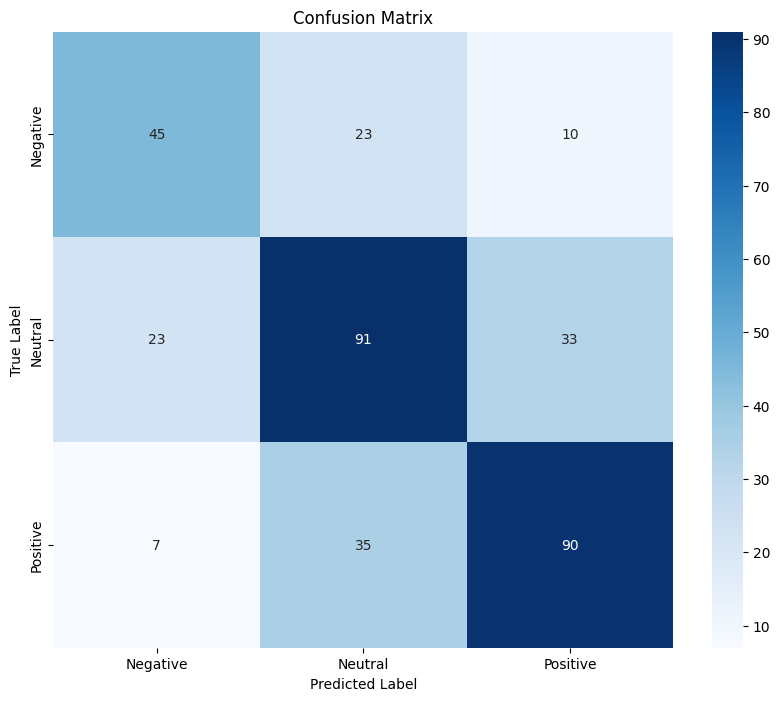


Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.58      0.59        78
     Neutral       0.61      0.62      0.61       147
    Positive       0.68      0.68      0.68       132

    accuracy                           0.63       357
   macro avg       0.63      0.63      0.63       357
weighted avg       0.63      0.63      0.63       357



In [18]:
# Get predictions and create confusion matrix
predictions = trainer.predict(val_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)
cm = confusion_matrix(val_labels, preds)

# Create labels for the plot
labels = ['Negative', 'Neutral', 'Positive']

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(val_labels, preds, target_names=labels))

### Step 8: Inference

Last step is predicting the sentiment on the unlabeled data, and then saving the results to a csv file.

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved model and tokenizer
model_path = "./fine_tuned_finbert_best"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = model.to(device)
model.eval()

# Function to predict sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_label = torch.argmax(predictions, dim=1).item()
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    return label_map[predicted_label]

# Read dataset
df = pd.read_csv('cleaned_unlabeled.csv')

# Add sentiment predictions as a new column
print("Starting sentiment prediction...")
df['sentiment'] = df['text'].apply(predict_sentiment)

# Save the updated dataset
df.to_csv('cleaned_unlabeled_with_sentiment.csv', index=False)

# Sample of results
print("\nSample of results:")
print(df[['text', 'sentiment']].head())

# Sentiment distribution
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

Starting sentiment prediction...

Sample of results:
                                                text sentiment
0  It's not about the money, it's about sending a...  positive
1  Math Professor Scott Steiner says the numbers ...   neutral
2  Exit the system The CEO of NASDAQ pushed to ha...   neutral
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...   neutral
4  Not to distract from GME, just thought our AMC...   neutral

Sentiment distribution:
sentiment
neutral     23383
positive    16959
negative    10874
Name: count, dtype: int64
